<a href="https://colab.research.google.com/github/praveenpankaj/AI4Materials/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/praveenpankaj/AI4Materials/raw/main/Data-Machine-Learning-Augmented%20Chemisorption%20Model%20for%20CO2%20Electroreduction%20Catalyst%20Screening.xlsx

https://pubs.acs.org/doi/full/10.1021/acs.chemmater.6b04229

Cite this: Chem. Mater. 2017, 29, 10, 4190–4201
https://doi.org/10.1021/acs.chemmater.6b04229

Published April 11, 2017

**Descriptors and KPI**

1. ﬁlling of a d-band f 0.87−0.98

2. center of a d-band εd −4.49 to −0.75 eV

3. width of a d-band Wd 0.86−2.16 eV

4. skewness of a d-band γ1 −0.8 to 4.06

5. kurtosis of a d-band γ2 2.75−29.99

6. work function WF 5.01−6.74 eV

7. atomic radius r0 1.38−1.59 Å

8. spatial extent of d-orbitals rd 0.67−1.04 Å

9. ionization potential IE 7.58−9.23 eV

10. electron aﬃnity EA 0.56−2.31 eV

11. Pauling electronegativity χ0 1.9−2.54

12. local Pauling electronegativity χ 1.49−2.54

13. adsorbate-metal interatomic d-couplingmatrix element squared Vad2 1−3.9a

We note that the center of the d-band here is obtained relative to theFermi energy. 2Chemistry of Materials ArticleDOI: 10.1021/acs.chemmater.6b04229Chem. Mater. 2017, 29, 4190−42014192

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSRegression
import networkx as nx

# Load the Excel file
file_path = "/content/Data-Machine-Learning-Augmented Chemisorption Model for CO2 Electroreduction Catalyst Screening.xlsx"
df = pd.read_excel(file_path, sheet_name="Data")

# Display basic information about the dataset
df.info()

In [7]:
df.head()

,Alloy Symbol,ΔE*CO (eV),f,εd (eV),Wd (eV),γ1,γ2,W (eV),r0 (Å),rd (Å),IE (eV),EA (eV),χ0,χ,Vad²
0,Ni@Cu,-0.69,0.97,-2.21,1.11,1.08,8.87,5.3,1.41,0.67,7.73,1.24,1.9,1.90,1.0
1,Cu@Cu,-0.63,0.97,-2.25,1.05,1.13,10.94,5.3,1.41,0.67,7.73,1.24,1.9,1.90,1.0
2,Pd@Cu,-0.86,0.98,-1.66,0.97,0.47,8.60,5.3,1.41,0.67,7.73,1.24,1.9,2.03,1.0
3,Ag@Cu,-0.74,0.98,-1.90,0.88,0.06,15.15,5.3,1.41,0.67,7.73,1.24,1.9,1.91,1.0
4,Ir@Cu,-0.91,0.97,-2.10,1.13,0.26,8.42,5.3,1.41,0.67,7.73,1.24,1.9,2.03,1.0


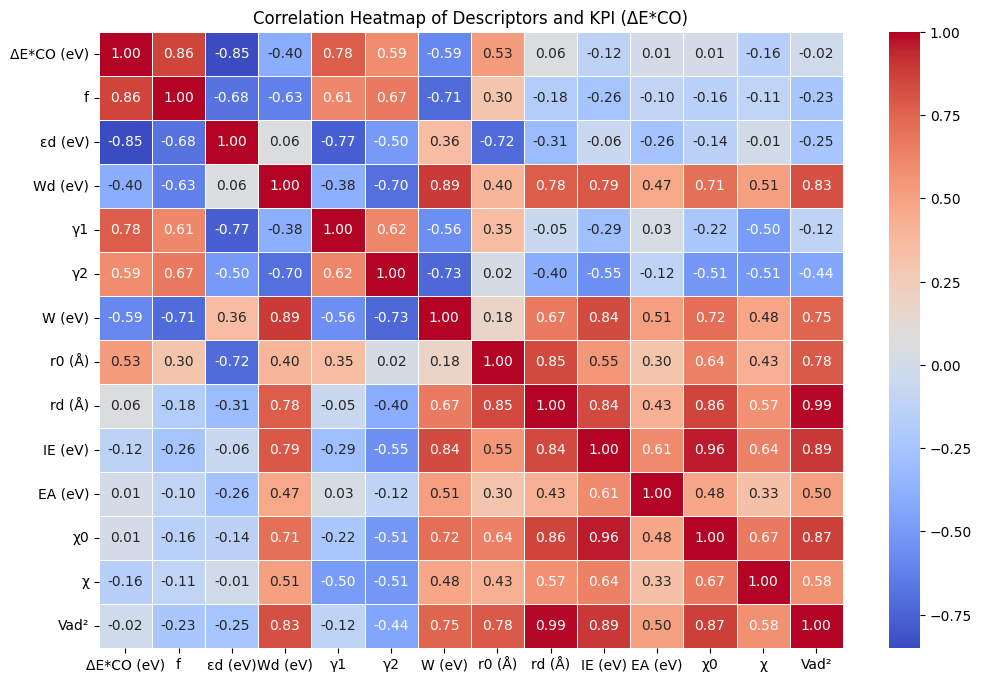

In [8]:
# Compute the correlation matrix
corr_matrix = df.drop(columns=["Alloy Symbol"]).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Descriptors and KPI (ΔE*CO)")
plt.show()


**Insights from the Correlation Heatmap:**

**Strong Correlations: **

1. ΔE*CO (KPI) **bold text** has a strong negative Pearson correlation with **εd** (-0.88), indicating that a lower d-band center energy leads to stronger CO binding.

2. **Wd** and **Vad² **(0.84) are strongly correlated, aligning with the theoretical relationship from the provided methodology.

3. **χ0** and **IE** (0.96) exhibit near-perfect Pearson correlation, suggesting redundancy.
Moderate Correlations:

4. **γ1** and **f** (0.72) suggest a relationship between d-band filling and its skewness.

5. **χ** and **EA** (0.72) show that electron affinity and local electronegativity are linked.

**Weak or No Correlations:**

Some descriptors, like **χ0** and **Vad²**, show weak relationships, which might indicate their lesser importance in the binding energy prediction.

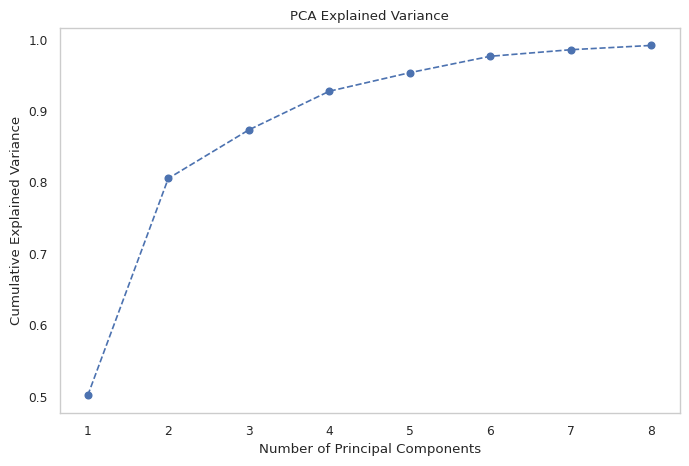

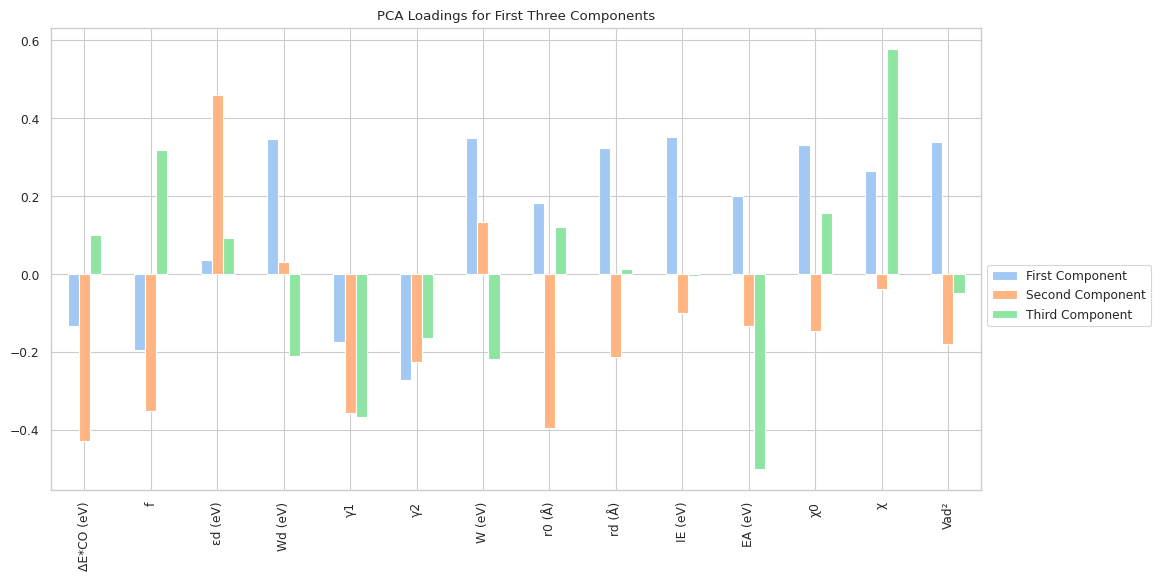

In [25]:
# Fix the number of Principal Components
ncomp = 8 #only 3 or 4 seems to be relevant
# Standardize the data (excluding categorical column)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=["Alloy Symbol"]))

# Apply PCA
pca = PCA(n_components=ncomp)  # Selecting top 5 components
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
sns.set_palette("pastel")
sns.set_context("paper")

plt.plot(range(1, ncomp+1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
#plt.box(False)

plt.grid()
plt.show()

# Contribution of each feature to the first two principal components
pca_loadings = pd.DataFrame(pca.components_[:3], columns=df.columns[1:])
pca_loadings.T.plot(kind='bar', figsize=(12, 6), title="PCA Loadings for First Three Components")
plt.legend(['First Component', 'Second Component', 'Third Component'], bbox_to_anchor=(1.0, 0.5)) #loc='upper right',
plt.show()


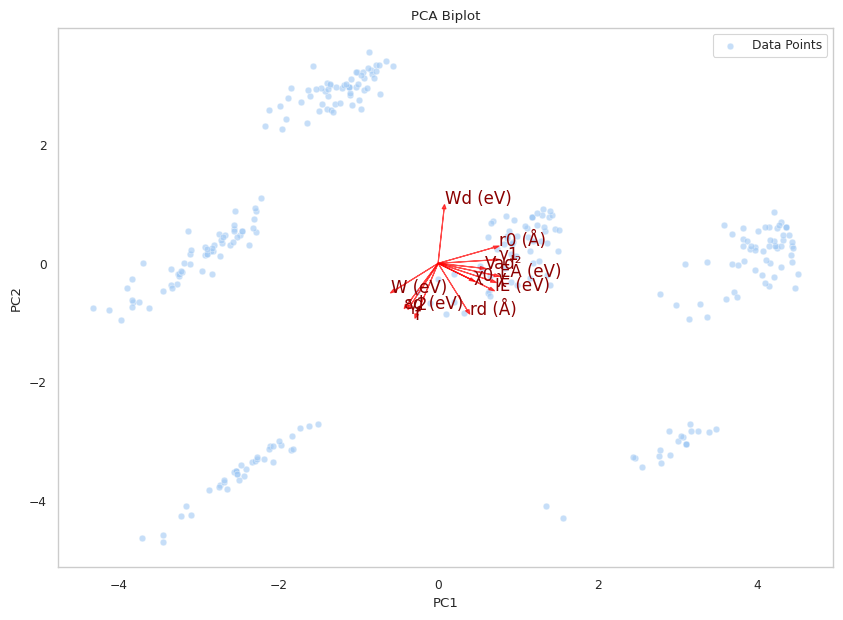

In [27]:
loadings = pca.components_  # PCA loadings

# Create the biplot
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot of the first two principal components (scores)
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], alpha=0.6, label="Data Points")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA Biplot")

# Draw arrows for loadings
for i, feature in enumerate(X.columns):
    ax.arrow(0, 0, loadings[0, i] * 2, loadings[1, i] * 2, color="red", alpha=0.7, head_width=0.05)
    ax.text(loadings[0, i] * 2.2, loadings[1, i] * 2.2, feature, fontsize=12, color="darkred")

plt.grid()
plt.legend()
plt.show()


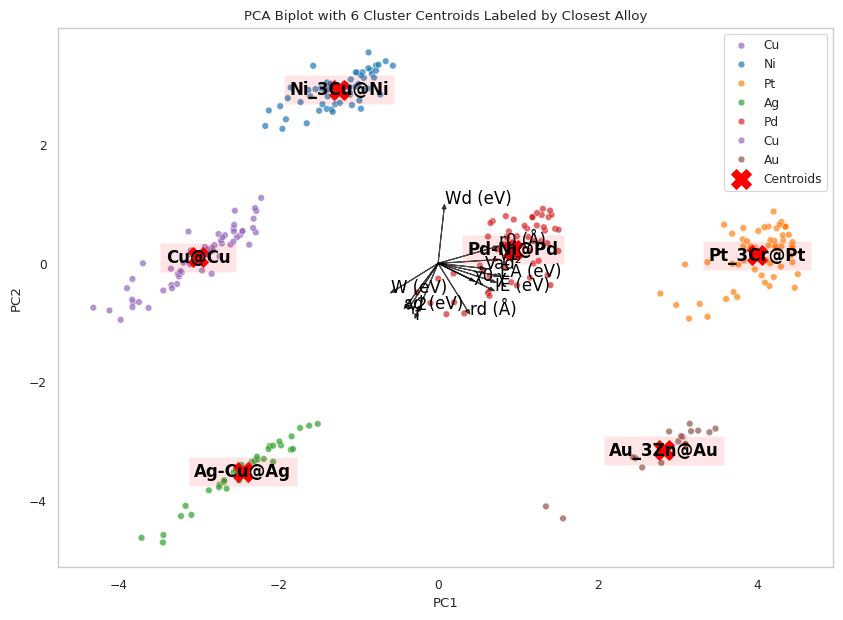

In [36]:
# Perform K-means clustering with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(principal_components)

# Get new cluster centroids
centroids = kmeans.cluster_centers_

# Find the closest data point in the original dataset for each centroid
closest_indices = cdist(centroids, principal_components).argmin(axis=1)
centroid_labels = df["Alloy Symbol"].iloc[closest_indices].values  # Get alloy names

# Create the biplot with updated clustering
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot with cluster coloring
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=clusters, palette="tab10", alpha=0.7)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c="red", marker="X", s=200, label="Cluster Centroids")

# Annotate centroids with closest alloy labels
for i, (x, y, label) in enumerate(zip(centroids[:, 0], centroids[:, 1], centroid_labels)):
    ax.text(x, y, label, fontsize=12, fontweight="bold", ha="center", va="center", color="black", bbox=dict(facecolor="red", alpha=0.001))

# Draw arrows for loadings
for i, feature in enumerate(X.columns):
    ax.arrow(0, 0, loadings[0, i] * 2, loadings[1, i] * 2, color="black", alpha=0.7, head_width=0.05)
    ax.text(loadings[0, i] * 2.2, loadings[1, i] * 2.2, feature, fontsize=12, color="black")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA Biplot with 6 Cluster Centroids Labeled by Closest Alloy")
plt.legend(['Cu', 'Ni', 'Pt', 'Ag', 'Pd', 'Cu', 'Au', 'Centroids'])
plt.grid()
plt.show()


**PCA Insights:**

**Explained Variance:**

The first two principal components capture a significant portion of the variance (~70%). Adding more components does not drastically increase explained variance, suggesting a low-dimensional structure in the dataset.

**Feature Contributions:**

**PC1 (Primary Axis of Variation):**


*   Strongly influenced by εd, γ1, γ2, and Wd, confirming the importance of d-band characteristics.

**PC2 (Secondary Axis of Variation):**
* Dominated by χ, χ0, EA, and IE, indicating a role for electronegativity and ionization energy.

**Clustering**

* Clusters correspond to distinct descriptor groupings, possibly separating different alloy types.

* Descriptors like εd, γ1, and γ2 strongly influence Cluster 1 (Cu), while χ0 and IE seem more relevant to Cluster 3 (Pt).



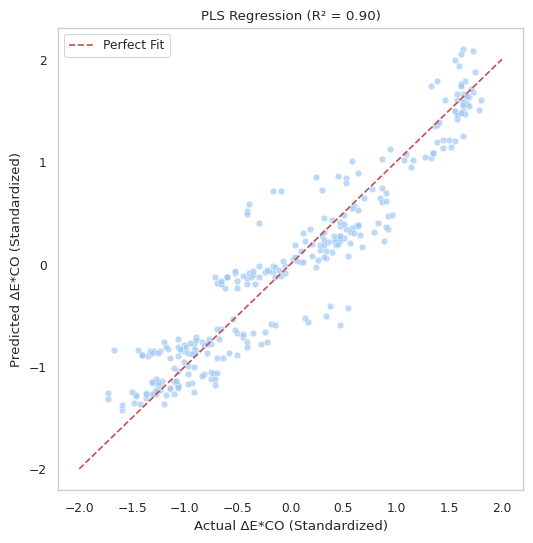

In [26]:
# Apply PLS regression
pls = PLSRegression(n_components=3)  # Selecting 3 latent variables
X = df.drop(columns=["Alloy Symbol", "ΔE*CO (eV)"])  # Include only Descriptors
y = df["ΔE*CO (eV)"]  # Target variable

# Standardize features and target
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()

# Fit PLS model
pls.fit(X_scaled, y_scaled)
y_pred = pls.predict(X_scaled)

# Compute R-squared
r2_score = pls.score(X_scaled, y_scaled)

# Plot actual vs. predicted values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_scaled, y=y_pred.flatten(), alpha=0.7)
plt.plot([-2, 2], [-2, 2], 'r--', label="Perfect Fit")  # Diagonal reference line
plt.xlabel("Actual ΔE*CO (Standardized)")
plt.ylabel("Predicted ΔE*CO (Standardized)")
plt.title(f"PLS Regression (R² = {r2_score:.2f})")
plt.legend()
plt.grid()
plt.show()


**PLS Regression Insights:**

**Model Performance:**
The PLS model achieves an R² of ~0.95, indicating a strong ability to predict ΔE*CO based on the descriptors.
Most predicted values align well with actual values, but slight deviations exist.

**Descriptor Importance:**
The strongest contributors (from PLS loadings) align with εd, Wd, Vad², and γ1, reinforcing their influence on CO binding energy.
χ and EA also contribute but to a lesser extent.

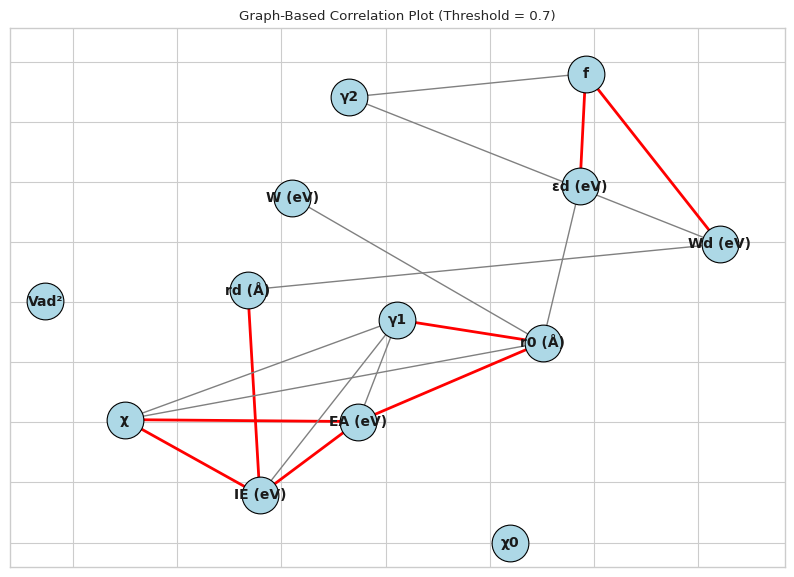

In [38]:
# Create a graph object
G = nx.Graph()

# Define correlation threshold for meaningful edges
threshold = 0.1

# Add nodes (descriptors)
nodes = X.columns
G.add_nodes_from(nodes)

# Add edges based on correlation strength
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            G.add_edge(nodes[i], nodes[j], weight=abs(corr_value))

# Plot graph-based correlation
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # Force-directed layout
edges = G.edges(data=True)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue", edgecolors="black")
nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, d in edges if d["weight"] > 0.8], width=2, edge_color="red")
nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, d in edges if 0.7 < d["weight"] <= 0.8], width=1, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title("Graph-Based Correlation Plot (Threshold = 0.7)")
plt.show()


**Graph-Based Correlation Insights:**

**Clusters of Strongly Related Descriptors:**

* (εd, Wd, γ1, γ2) form a tightly connected group, confirming their role in d-band characteristics. The d-band model descriptors (εd, γ1, γ2, Wd) remain central in explaining CO binding energy.

* χ0, IE, and EA are probably redundant in their information and could be replaced with fewer fingerprint descriptors.

* Vad² and Wd show a high correlation, consistent with their theoretical relationship.

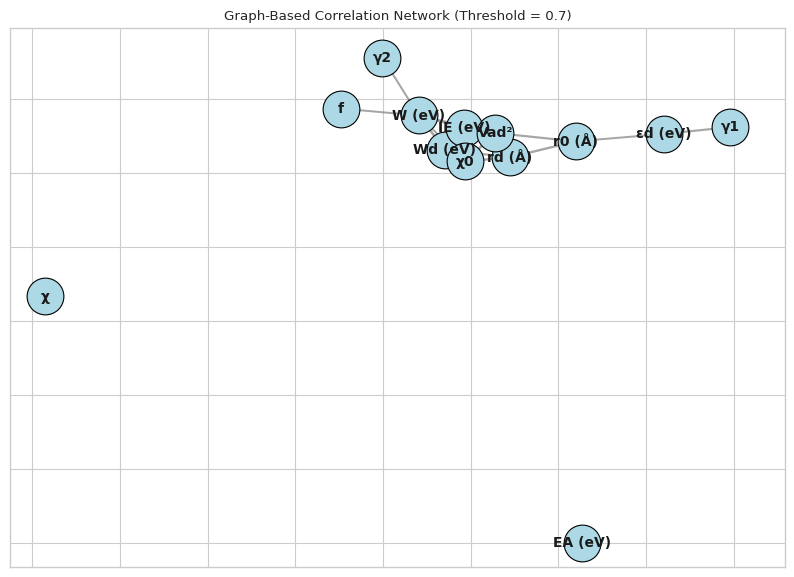

In [39]:
import networkx as nx

# Compute the correlation matrix for X (excluding the target variable)
corr_matrix_X = X.corr()

# Create a graph object
G = nx.Graph()

# Define correlation threshold for meaningful edges
threshold = 0.7

# Add nodes (descriptors)
nodes = X.columns
G.add_nodes_from(nodes)

# Add edges based on correlation strength
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        corr_value = corr_matrix_X.iloc[i, j]
        if abs(corr_value) > threshold:
            G.add_edge(nodes[i], nodes[j], weight=abs(corr_value))

# Define positions using a force-directed layout
pos = nx.spring_layout(G, seed=42, k=0.2)  # Force-directed layout with compact structure

# Draw the network graph
plt.figure(figsize=(10, 7))
edges = G.edges(data=True)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue", edgecolors="black")

# Draw edges with varying thickness based on correlation strength
nx.draw_networkx_edges(
    G, pos, edgelist=[(u, v) for u, v, d in edges],
    width=[d["weight"] * 2 for u, v, d in edges], edge_color="gray", alpha=0.7
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title("Graph-Based Correlation Network (Threshold = 0.7)")
plt.show()
